In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4
Fri Nov 24 17:00:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   49C    P0   125W / 275W |  23505MiB / 81920MiB |     60%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM... 

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

import time

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[17:00:36.427] INFO   CaloQVAE                                          Willkommen!
[17:00:36.428] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[17:00:36.945] INFO   numexpr.utils                                     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[17:00:36.945] INFO   numexpr.utils                                     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[17:00:36.946] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2023-11-24 17:00:37,356 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[17:00:37.356] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [6]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [21]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[17:08:54.834] INFO   data.dataManager                                  Loading Data
[17:09:01.037] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3ec8860410>: 80000 events, 625 batches
[17:09:01.038] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3ec883b1d0>: 10000 events, 10 batches
[17:09:01.038] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3ef28012d0>: 10000 events, 10 batches
[17:09:03.133] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNN
2023-11-24 17:09:03

Initializing NetworkV3


In [22]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[17:09:06.749] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 6480])
[17:09:06.750] INFO   wandb                                             Watching
[17:09:06.753] INFO   engine.engineAtlas                                Setting up engine Atlas.
[17:09:06.753] INFO   engine.engineCaloV3                               Setting up engine Calo.
[17:09:06.753] INFO   engine.engine                                     Setting up default engine.


In [23]:
# config=compose(config_name="config.yaml")
config_2=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config_2, mode='disabled')
modelCreator_2 = ModelCreator(cfg=config_2)
dataMgr_2 = DataManager(cfg=config_2)
#initialise data loaders
dataMgr_2.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr_2.pre_processing()

if config_2.model.activation_fct.lower()=="relu":
    modelCreator_2.default_activation_fct=torch.nn.ReLU()
elif config_2.model.activation_fct.lower()=="tanh":
    modelCreator_2.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator_2.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model_2=modelCreator_2.init_model(dataMgr=dataMgr_2)

#create the NN infrastructure
model_2.create_networks()

engine_2=instantiate(config_2.engine, config_2)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine_2._config=config_2
#add dataMgr instance to engine namespace
engine_2.data_mgr=dataMgr_2
#add device instance to engine namespace
engine_2.device=dev    
#instantiate and register optimisation algorithm
engine_2.optimiser = torch.optim.Adam(model_2.parameters(),
                                    lr=config_2.engine.learning_rate)
#add the model instance to the engine namespace
engine_2.model = model_2
# add the modelCreator instance to engine namespace
engine_2.model_creator = modelCreator_2
engine_2.model = engine_2.model.to(dev)

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[17:09:07.349] INFO   data.dataManager                                  Loading Data
[17:09:13.745] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3e984f90d0>: 80000 events, 625 batches
[17:09:13.746] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3e90194b90>: 10000 events, 10 batches
[17:09:13.746] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3e90194b50>: 10000 events, 10 batches
[17:09:15.868] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNN
2023-11-24 17:09:15

Initializing NetworkV3


[17:09:19.502] INFO   engine.engineAtlas                                Setting up engine Atlas.
[17:09:19.502] INFO   engine.engineCaloV3                               Setting up engine Calo.
[17:09:19.503] INFO   engine.engine                                     Setting up default engine.


In [24]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[17:09:26.359] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3ef946afd0>: 80000 events, 625 batches
[17:09:26.360] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3ec8957f10>: 10000 events, 10 batches
[17:09:26.361] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f3ef2c63e50>: 10000 events, 10 batches


In [25]:
###LOAD MODEL

In [26]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])
                    
                    
def load_RBM_state(run_path, device):
        logger.info("Loading RBM state")
        model_loc = run_path
        # Load the dictionary with all tensors mapped to the CPU
        loaded_dict = torch.load(model_loc, map_location=device)
        return loaded_dict
    
# ww = load_RBM_state("/home/javier/Projects/CaloQVAE/outputs/2023-11-20/16-54-48/wandb/latest-run/files/RBM_1_0_weights.pth", dev)

In [27]:
# # enchanted-newt-231
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-31/19-40-06/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'enchanted-newt-231'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-31/19-40-06/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # polished-night-232
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-06/15-15-56/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'polished-night-232'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-06/15-15-56/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
    
# # wobbly-meadow-233 #hits not energy conditioned
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-06/22-44-20/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'wobbly-meadow-233'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-06/22-44-20/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


# # apricot-terrain-235 <---- Fully connected NN
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-07/19-48-38/wandb/latest-run/files/GumBoltAtlasPRBMFCN_atlas_default_latest.pth"
# modelname = 'apricot-terrain-235'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-07/19-48-38/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


# robust-dawn-236
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-07/20-01-41/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'robust-dawn-236'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-07/20-01-41/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True


# # faithful-cosmos-237
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-15/20-19-48/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'faithful-cosmos-237'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-15/20-19-48/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    

# super-valley-246 | CNN + Fully conditioned + scaled data
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'super-valley-246'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True
    
    
# wise-pond-247 | CNN + Unconditioned + scaled data
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-21/19-09-17/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'wise-pond-247'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-21/19-09-17/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True
    
    
# # revived-grass-249 | CNN + Unconditioned + unscaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-21/19-09-17/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'revived-grass-249'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-21/19-09-17/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # dark-eon-250 | CNN + Enc conditioned + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-21/19-31-22/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'dark-eon-250'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-21/19-31-22/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # balmy-grass-251 | CNN + Enc conditioned + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-22/19-46-25/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'balmy-grass-251'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-22/19-46-25/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
engine.model.eval();

GumBoltAtlasPRBMCNN
electron-ds2
True False
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [14]:
lnZais = engine.model.stater.AIS(30).detach().cpu().item()

In [15]:
lnZrais = engine.model.stater.RAIS(20).detach().cpu().item()
print(lnZais, lnZrais)

3831.41748046875 3832.21435546875


In [16]:
lnZais_rdm = engine_2.model.stater.AIS(30).detach().cpu().item()
lnZrais_rdm = engine_2.model.stater.RAIS(20).detach().cpu().item()
print(lnZais_rdm, lnZrais_rdm)

2720.5166015625 2722.32470703125


In [17]:
# lnZais

In [18]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2', 'pion1':'Dataset 1: π'}

In [18]:
xx = next(iter(test_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

torch.Size([1024, 6480])


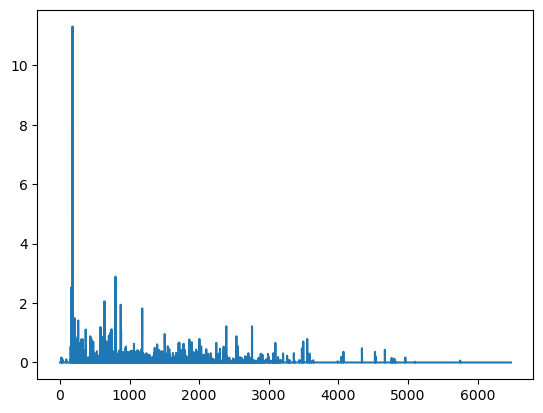

In [19]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

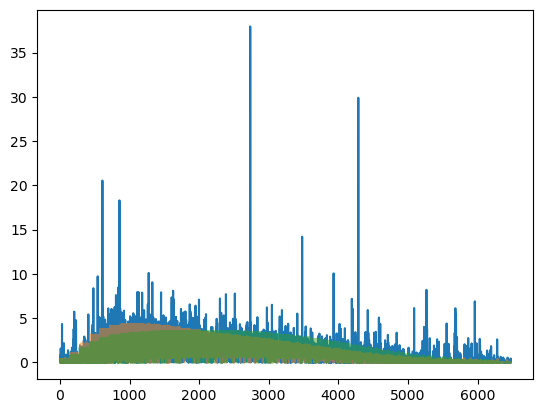

In [20]:
with torch.no_grad():
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    # if reducedata:
        # in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), True)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
idx = 12
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(sample_data.detach().cpu().numpy()[idx,:], alpha=0.5)

In [46]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    # enIn = torch.cat((in_data, true_energy), dim=1)
    # beta, post_logits, post_samples = engine.model.encoder(enIn)
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
# plt.plot(post_samples[0][0,:].detach().cpu().numpy())
post_samples = torch.cat(post_samples, 1)

In [21]:
# t0 = time.time() outputs = net(x) torch.cuda.current_stream().synchronize() t1 = time.time()

decoder_time = []
for i in range(500):
    # start = time.process_time()
    start = time.time()
    output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
    torch.cuda.current_stream().synchronize()
    t1 = time.time()
    decoder_time.append(t1 - start)
    # decoder_time.append(time.process_time() - start)

In [22]:
print(np.mean(decoder_time), np.std(decoder_time))

0.010469470977783203 0.0005546670617905547


Text(0, 0.5, 'decoder time (s)')

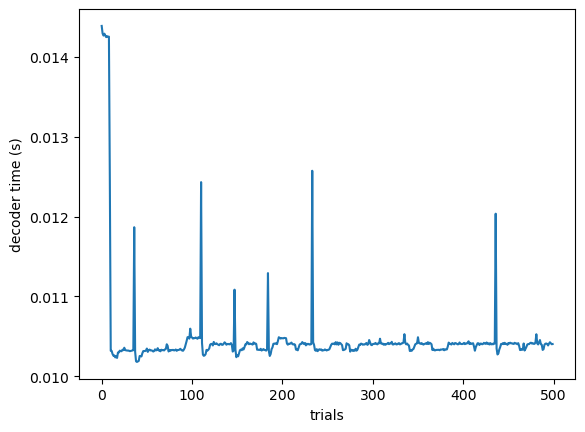

In [23]:
plt.plot(decoder_time)
plt.xlabel("trials")
plt.ylabel("decoder time (s)")

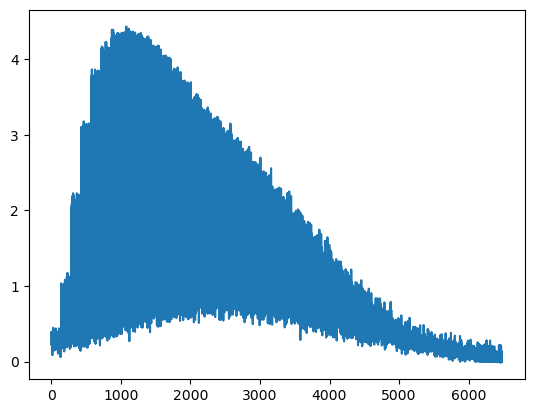

In [27]:
# post_samples = torch.cat([post_samples, true_energy], dim=1)
# post_samples = torch.cat(post_samples,1)
# output_hits, output_activations = engine.model.decoder(post_samples)
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())


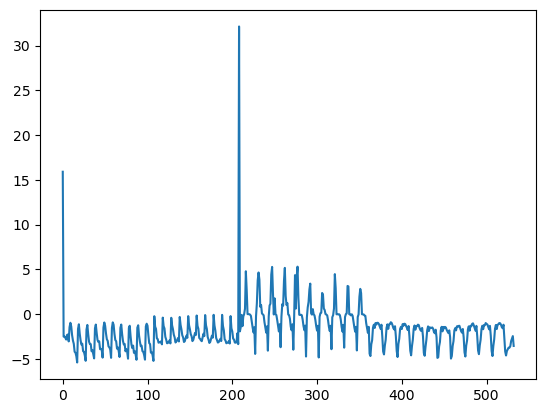

In [26]:
# self._hit_smoothing_dist_mod(output_hits, beta, is_training)
plt.plot(output_hits[1,:].detach().cpu().numpy())
beta = torch.tensor(5, dtype=torch.float, device=output_hits.device, requires_grad=False)

In [68]:
beta = torch.tensor(1, dtype=torch.float, device=output_hits.device, requires_grad=False)

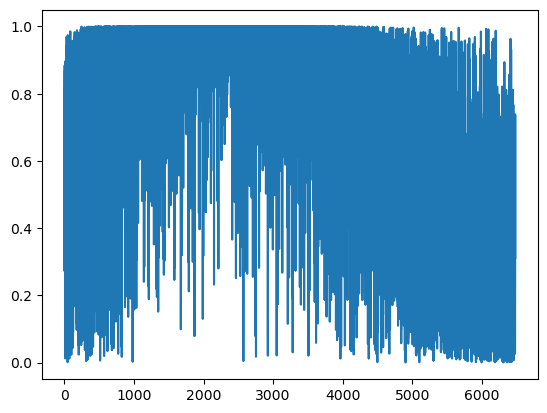

In [69]:
plt.plot(engine.model._hit_smoothing_dist_mod(output_hits, beta, True)[2,:].detach().cpu().numpy())

In [29]:
weight_dict = engine.model.prior.weight_dict

In [30]:
(weight_dict['01']==0).sum()

tensor(259267, device='cuda:0')

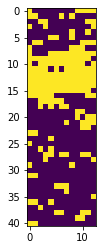

In [30]:
# engine.model._hit_smoothing_dist_mod(output_hits, torch.Tensor([5]), is_training=False)[idx,:].detach().cpu()
idx=5
# plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(23,16))
plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(41,13))

In [39]:
# fwd_output.output_activations.shape

In [554]:
(output_hits.sum(dim=0) == 0).sum()
engine._config.model.output_smoothing_fct

# engine.model._energy_activation_fct
beta = torch.tensor(engine._config.model.output_smoothing_fct, dtype=torch.float, device=output_hits.device, requires_grad=False)
output = engine.model._energy_activation_fct(output_activations) * engine.model._hit_smoothing_dist_mod(output_hits, beta, False)
o1 = engine.model._energy_activation_fct(output_activations)
o2 = engine.model._hit_smoothing_dist_mod(output_hits, beta, False)

In [555]:
(output.sum(dim=0) == 0).sum()
(o1.sum(dim=0) == 0).sum()
# (o2.sum(dim=0) == 0).sum()
# (in_data.sum(dim=0) == 0).sum()
# in_data.shape
# engine.model._energy_activation_fct

tensor(0, device='cuda:0')

In [19]:
directory_path = f'/home/javier/Projects/CaloQVAE/figs/{modelname}'
if not os.path.isdir(directory_path):
    os.mkdir(directory_path) 
    print(modelname)
else:
    pass

In [28]:
beta, beta_list, rbm_energy_list, dwave_energies_list = engine.model.find_beta(10.0, 0.01, 30)

Epoch 0: beta = 10.0
Epoch 1: beta = 8.594875793457032
Epoch 2: beta = 8.109177551269532
Epoch 3: beta = 8.057405700683594
Epoch 4: beta = 7.875581359863282
Epoch 5: beta = 7.766719055175781
Epoch 6: beta = 7.738727722167969
Epoch 7: beta = 7.736074829101563
Epoch 8: beta = 7.692644653320313
Epoch 9: beta = 7.697996520996094
Epoch 10: beta = 7.618302001953126
Epoch 11: beta = 7.682867126464845
Epoch 12: beta = 7.709289550781251
Epoch 13: beta = 7.661607666015626
Epoch 14: beta = 7.6663494873046885
Epoch 15: beta = 7.6361022949218755
Epoch 16: beta = 7.723333129882813
Epoch 17: beta = 7.718641662597657
Epoch 18: beta = 7.926458740234375
Epoch 19: beta = 7.94449462890625
Epoch 20: beta = 7.860755615234376
Epoch 21: beta = 7.877700805664063
Epoch 22: beta = 7.902145385742188
Epoch 23: beta = 7.927779541015626
Epoch 24: beta = 7.889776000976564
Epoch 25: beta = 7.795010375976564
Epoch 26: beta = 7.808413391113283
Epoch 27: beta = 7.735089416503908
Epoch 28: beta = 7.715351867675783
Epoch 2

In [29]:
engine.model._qpu_sampler.properties["chip_id"]

'Advantage_system6.3'

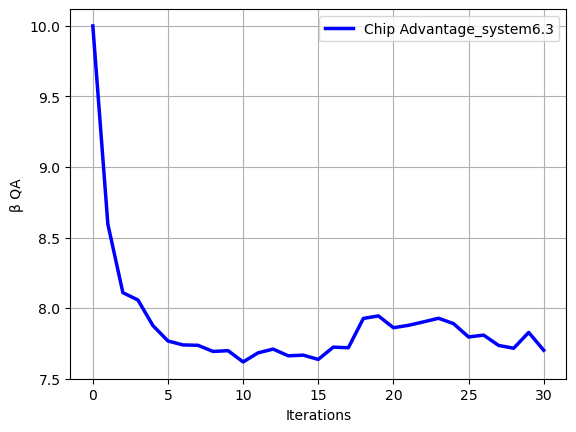

In [30]:
plt.plot(beta_list, linewidth=2.5, color="b" )
plt.xlabel("Iterations")
plt.ylabel("β QA")
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'])
# plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
# engine.model.eval();
# (engine.model.prior._weight_dict['01'] == 0).sum(axis=1)

In [31]:
Hoffset = -(sum([engine.model.prior.bias_dict[key].sum().detach().cpu().item() for key in engine.model.prior.bias_dict.keys()])/2 + sum([engine.model.prior.weight_dict[key].sum().detach().cpu().item() for key in engine.model.prior.weight_dict.keys()])/4)


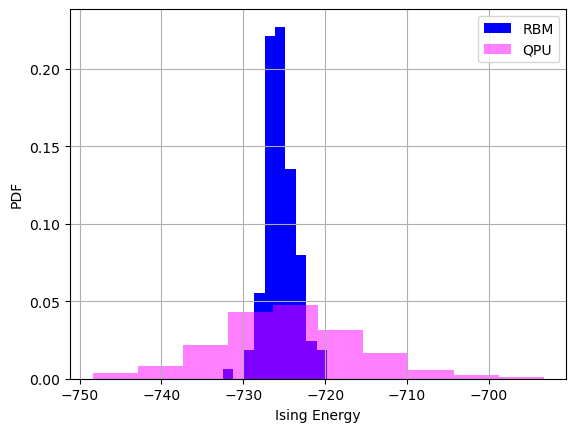

128


In [33]:
plt.hist(rbm_energy_list[-1] + Hoffset, density=True, color="b")
plt.hist(dwave_energies_list[-1] + Hoffset, density=True, fc=(1, 0, 1, 0.5))
plt.xlabel("Ising Energy")
plt.ylabel("PDF")
plt.legend(["RBM", "QPU"])
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/Ising_energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(len(rbm_energy_list[-1]))

In [35]:
from utils.hists.RBMenergyHist import generate_rbm_energy_hist

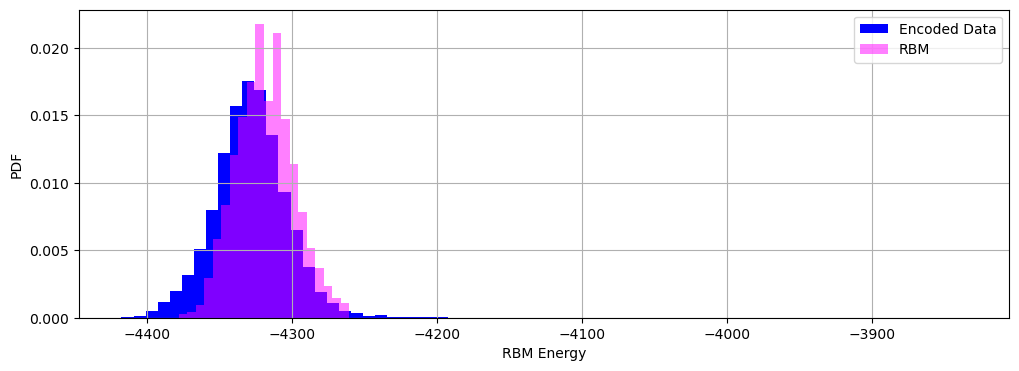

In [36]:
generate_rbm_energy_hist(engine, config.model, val_loader, False)

In [35]:
# Encoded data and RBM

In [37]:

partition_size=config.model.n_latent_nodes
encoded_data = []
energy_encoded_data = []

encoded_data_rdm = []
energy_encoded_data_rdm = []
engine.model.eval()
engine_2.model.eval()
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        encoded_data.append(post_samples.detach().cpu())
        energy_encoded_data.append(post_samples_energy.detach().cpu())
        
        #Rdm model
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine_2.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine_2.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        encoded_data_rdm.append(post_samples.detach().cpu())
        energy_encoded_data_rdm.append(post_samples_energy.detach().cpu())

encoded_data = torch.cat(encoded_data, dim=0)
energy_encoded_data = torch.cat(energy_encoded_data, dim=0)
        
encoded_data_rdm = torch.cat(encoded_data_rdm, dim=0)
energy_encoded_data_rdm = torch.cat(energy_encoded_data_rdm, dim=0)

p1,p2,p3,p4 = post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], \
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size]

energy_rbm_data = []
energy_rbm_rdm_data = []
with torch.no_grad():
    for i in range(10):
        # if i == 0:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0)
        # else:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0, p1, p2, p3, p4)
        p1, p2, p3, p4 = engine.model.sampler.block_gibbs_sampling()
        rbm_samples_energy = engine.model.stater.energy_samples(p1, p2, p3, p4, 1.0)
        energy_rbm_data.append(rbm_samples_energy.detach().cpu())
        
        if i == 0:
            p1_r, p2_r, p3_r, p4_r = engine_2.model.stater.block_gibbs_sampling_ais(1.0)
        else:
            p1_r, p2_r, p3_r, p4_r = engine_2.model.stater.block_gibbs_sampling_ais(1.0, p1_r, p2_r, p3_r, p4_r)
        rbm_rdm_samples_energy = engine_2.model.stater.energy_samples(p1_r, p2_r, p3_r, p4_r, 1.0)
        energy_rbm_rdm_data.append(rbm_rdm_samples_energy.detach().cpu())
    
energy_rbm_data = torch.cat(energy_rbm_data, dim=0)
energy_rbm_rdm_data = torch.cat(energy_rbm_rdm_data, dim=0)

In [38]:
print("LL of trained model", -energy_encoded_data.mean() - lnZais)
print("LL of trained model. Gibbs samples data", -energy_rbm_data.mean() - lnZais)
print("LL of rdm model", -energy_encoded_data_rdm.mean() - lnZrais_rdm)
print("LL of rdm model. Gibbs Samples data", -energy_rbm_rdm_data.mean() - lnZrais_rdm)
print(lnZais, lnZais_rdm)

LL of trained model tensor(497.1865)
LL of trained model. Gibbs samples data tensor(487.0449)
LL of rdm model tensor(-2752.2070)
LL of rdm model. Gibbs Samples data tensor(-721.2595)
3831.41748046875 2720.5166015625


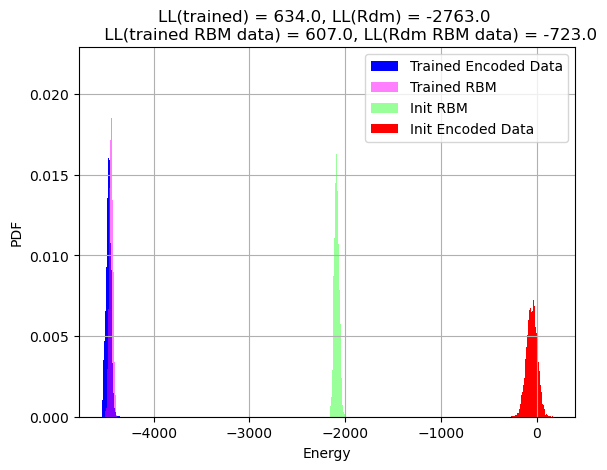

In [44]:
plt.hist(energy_encoded_data.numpy(), bins=70, linewidth=2.5, color="b", density=True)
plt.hist(energy_rbm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(1, 0, 1, 0.5))
plt.hist(energy_rbm_rdm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(0.5, 1.0, 0.5, 0.8))
plt.hist(energy_encoded_data_rdm.numpy(), bins=70, linewidth=2.5, color="r", density=True)

plt.xlabel("Energy")
plt.ylabel("PDF")
plt.legend(["Trained Encoded Data", "Trained RBM", "Init RBM", "Init Encoded Data"])
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
plt.title(f'LL(trained) = {np.round(-energy_encoded_data.mean() - lnZais)}, LL(Rdm) = {np.round(-energy_encoded_data_rdm.mean() - lnZrais_rdm)} \n \
        LL(trained RBM data) = {np.round(-energy_rbm_data.mean() - lnZais)}, LL(Rdm RBM data) = {np.round(-energy_rbm_rdm_data.mean() - lnZrais_rdm)}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

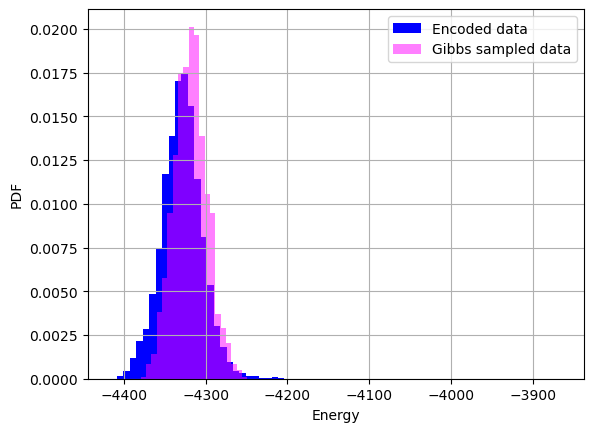

In [39]:
plt.hist(energy_encoded_data.numpy(), bins=70, linewidth=2.5, color="b", density=True)
plt.hist(energy_rbm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(1, 0, 1, 0.5))
# plt.hist(energy_rbm_rdm_data.numpy(), bins=20, linewidth=2.5, color="cyan", density=True, fc=(0.5, 1.0, 0.5, 0.8))
# plt.hist(energy_encoded_data_rdm.numpy(), bins=70, linewidth=2.5, color="r", density=True)

plt.xlabel("Energy")
plt.ylabel("PDF")
plt.legend(["Encoded data", "Gibbs sampled data", "Init RBM", "Init Encoded Data"])
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
# plt.title(f'LL(trained) = {np.round(-energy_encoded_data.mean() - lnZais)}, LL(Rdm) = {np.round(-energy_encoded_data_rdm.mean() - lnZrais_rdm)} \n \
        # LL(trained RBM data) = {np.round(-energy_rbm_data.mean() - lnZais)}, LL(Rdm RBM data) = {np.round(-energy_rbm_rdm_data.mean() - lnZrais_rdm)}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_2_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
# Sparsity and Energy

In [43]:
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_samples_qpu = []

# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        fwd_output = engine.model((in_data, true_energy), False)
        if reducedata:
            in_data = engine._reduceinv(in_data, true_energy, R=R)
            recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
            recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
            sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
            sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
        else:
            in_data = in_data.detach().cpu()*1000
            recon_data = fwd_output.output_activations.detach().cpu()*1000
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
            sample_data = sample_data.detach().cpu()*1000

        # xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
    #     if engine._config.engine.cl_lambda:
    #         labelsrecon_samples.append(fwd_output.labels.detach().cpu())
    #         labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )

    #         en_labels.append(true_energy.detach().cpu())

        xtarget_samples.append(in_data.detach().cpu())
        xrecon_samples.append( recon_data.detach().cpu())
        xgen_samples.append( sample_data.detach().cpu())
        xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
        entarget_samples.append(true_energy.detach().cpu())

        # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# if engine._config.engine.cl_lambda:
#     labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
#     labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
#     en_labels = torch.cat(en_labels, dim=0)

#     lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
#     l = torch.argmax(labelstarget_samples, dim=1).numpy()


In [42]:
(xgen_samples.sum(dim=0) == 0).sum()
(xrecon_samples.sum(dim=0) == 0).sum()
# (xtarget_samples.sum(dim=0) == 0).sum()
# print((xgen_samples.sum(dim=0) == 0).nonzero(as_tuple=True))
# print((xrecon_samples.sum(dim=0) == 0).nonzero(as_tuple=True))

tensor(14)

In [77]:
# Random RBM
# engine.model.sampler._prbm._bias_dict = load_RBM_state(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/RBM/RBM_1_9_biases.pth', dev)
# engine.model.sampler._prbm._weight_dict = load_RBM_state(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/RBM/RBM_1_9_weights.pth', dev)
engine.model.sampler._prbm._bias_dict = engine_2.model.sampler._prbm._bias_dict
engine.model.sampler._prbm._weight_dict = engine_2.model.sampler._prbm._weight_dict
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_samples_qpu = []

# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        fwd_output = engine.model((in_data, true_energy), False)
        if reducedata:
            in_data = engine._reduceinv(in_data, true_energy, R=R)
            recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
            recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
            sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
            sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
        else:
            in_data = in_data.detach().cpu()*1000
            recon_data = fwd_output.output_activations.detach().cpu()*1000
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
            sample_data = sample_data.detach().cpu()*1000

        # xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
    #     if engine._config.engine.cl_lambda:
    #         labelsrecon_samples.append(fwd_output.labels.detach().cpu())
    #         labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )

    #         en_labels.append(true_energy.detach().cpu())

        xtarget_samples.append(in_data.detach().cpu())
        xrecon_samples.append( recon_data.detach().cpu())
        xgen_samples.append( sample_data.detach().cpu())
        xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
        entarget_samples.append(true_energy.detach().cpu())

        # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# if engine._config.engine.cl_lambda:
#     labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
#     labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
#     en_labels = torch.cat(en_labels, dim=0)

#     lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
#     l = torch.argmax(labelstarget_samples, dim=1).numpy()



In [44]:
print("mean qpu time", np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_qpu[i][0] for i in range(9)]))
print("mean gpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_gpu[i][0] for i in range(9)]))
print("mean gpu time/mean qpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)])/np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]))


mean qpu time 0.07484855213099056 0.0008544467559427857
mean gpu time 1.9804112023363512 0.034705626437319705
mean gpu time/mean qpu time 26.45891130760263


In [119]:
# plt.hist(sample_energies.sum(dim=1).detach().cpu().numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="b")
# plt.hist(sample_energies_qpu.sum(dim=1).detach().cpu().numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")

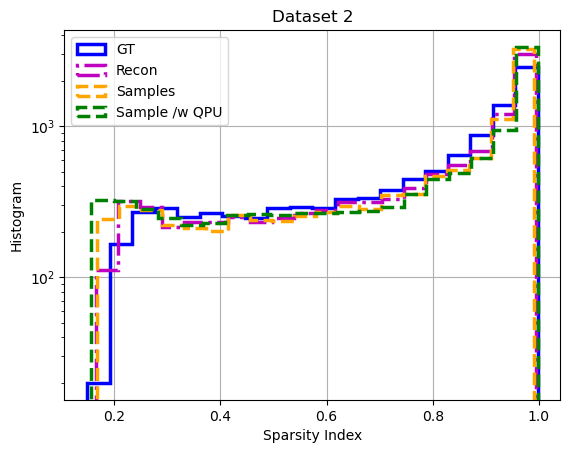

In [46]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

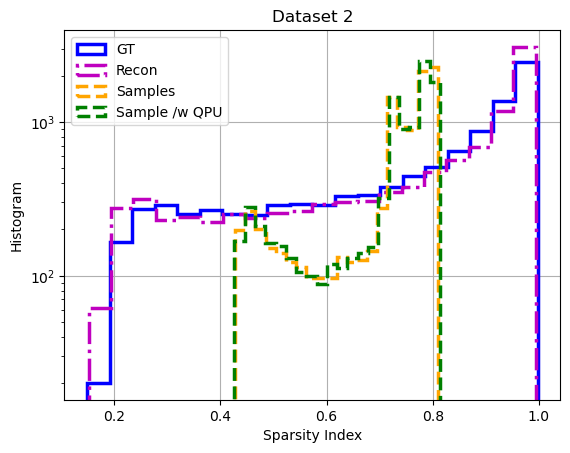

In [78]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_RDM_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [36]:
# idxPrev = 0
# # for i,idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate([16*9*i for i in range(1,5)]):
# # for i,idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.xlabel("Sparsity Index")
#     plt.ylabel("Histogram")
#     plt.legend(["GT", "Recon", "Sample"])
#     plt.title(f'{part} Layer {i}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

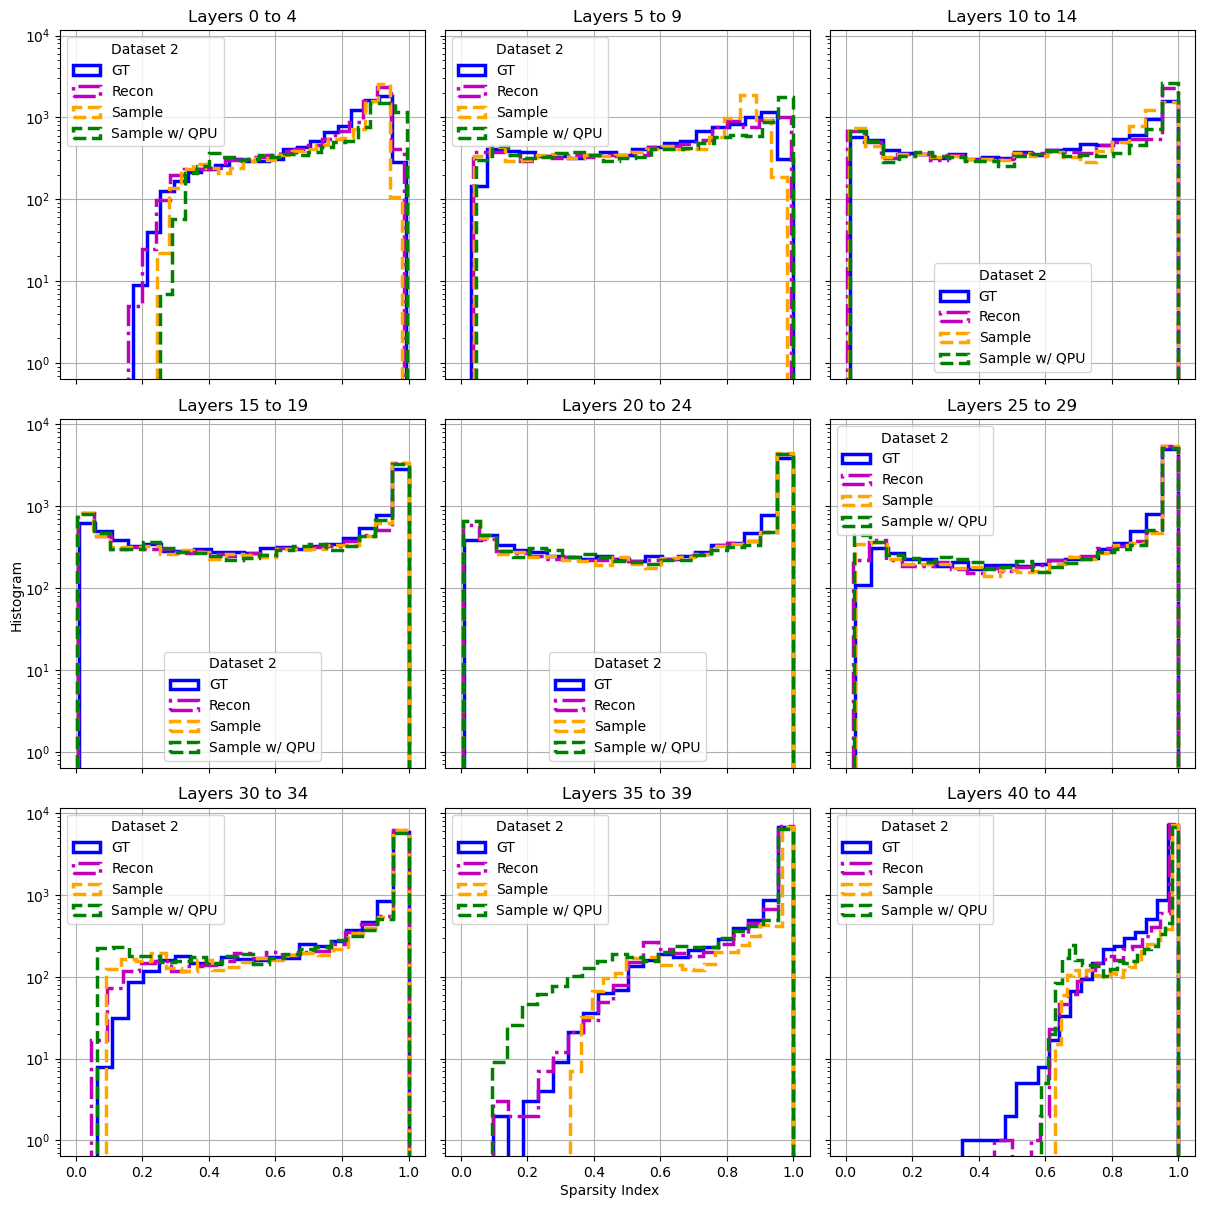

In [47]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, 0.0, 'Sparsity Index', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
    ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


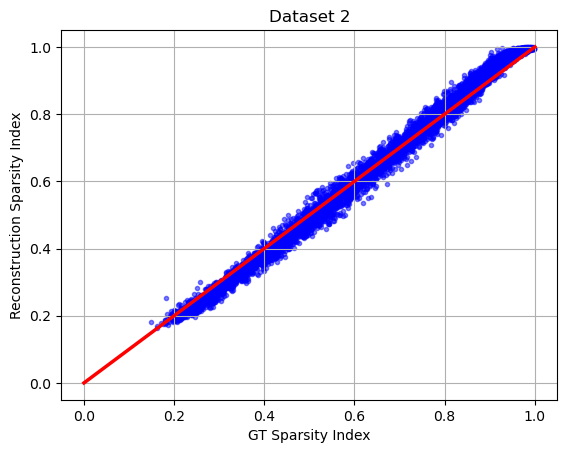

In [27]:
plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.5, color="b")
plt.plot([0,1],[0,1], c='red', lw=2.5)
plt.xlabel('GT Sparsity Index')
plt.ylabel('Reconstruction Sparsity Index')
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [49]:
# idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# # for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.scatter(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), marker='.', alpha=.2)
#     plt.plot([0,1],[0,1], c='red', lw=2)
#     plt.xlabel('sparsity index input')
#     plt.ylabel('sparsity index recon')
#     plt.title(f'{part}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

In [50]:
E_right = 60000
E_left = 10000
tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]
len(idxEnFilter)

2555

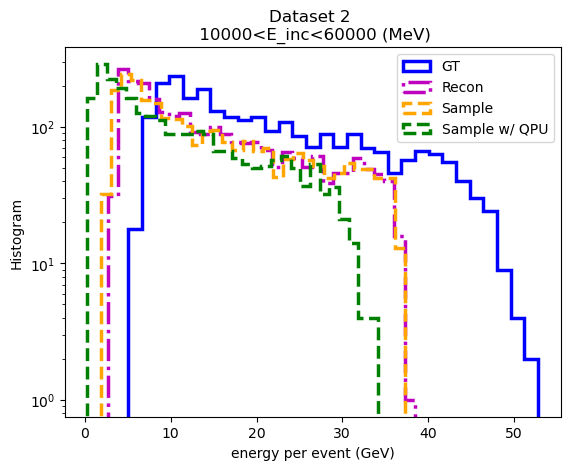

In [51]:
plt.hist(xtarget_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
plt.hist(xgen_samples_qpu[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")

plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]} \n {E_left}<E_inc<{E_right} (MeV)')
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_slice_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

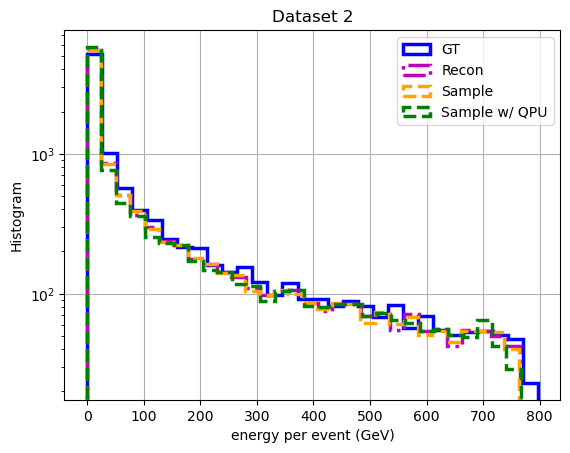

torch.Size([10000, 6480])


In [52]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashed")
plt.hist(xgen_samples_qpu.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="green", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="b")
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(xgen_samples.shape)

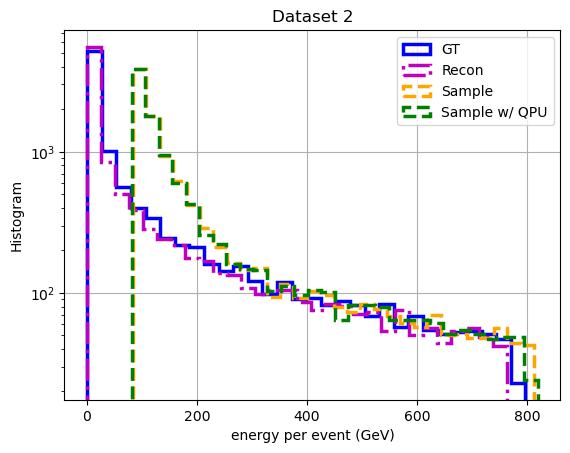

torch.Size([10000, 6480])


In [79]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashed")
plt.hist(xgen_samples_qpu.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="green", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="b")
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_RDM_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(xgen_samples.shape)

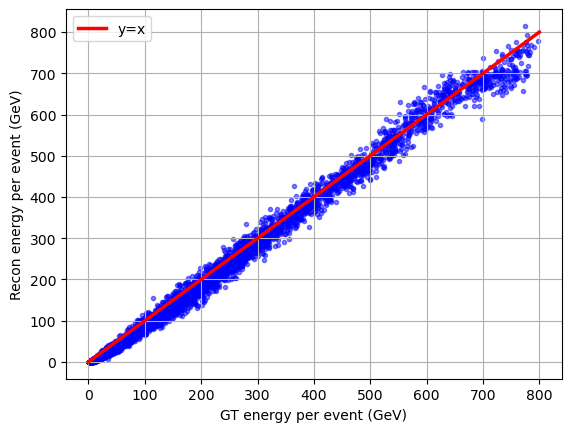

In [29]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
plt.plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
plt.legend()
plt.grid("True")
plt.xlabel("GT energy per event (GeV)")
plt.ylabel("Recon energy per event (GeV)")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

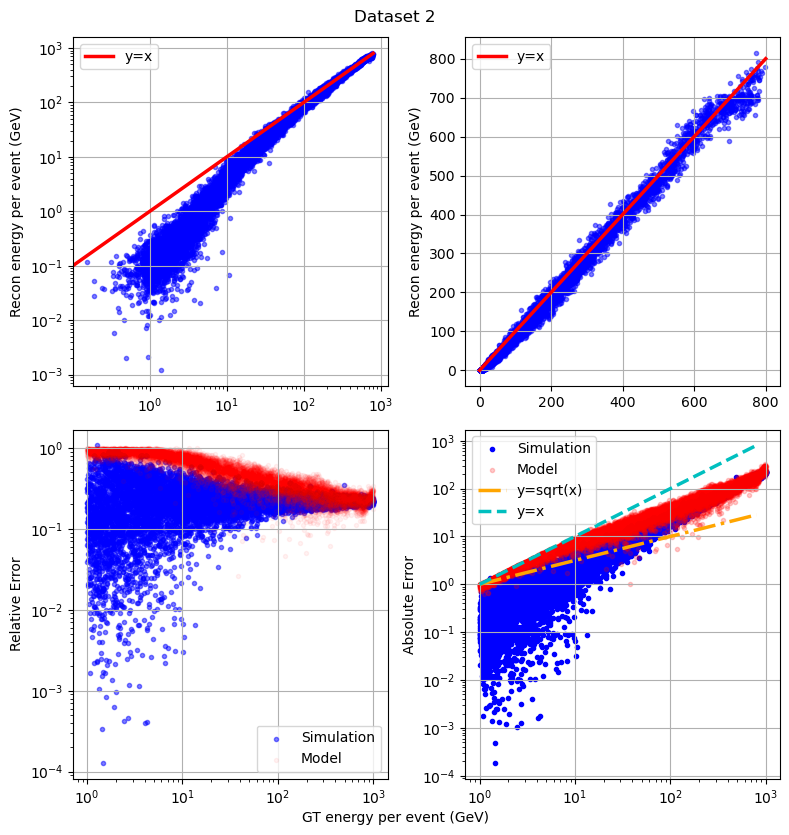

In [30]:
fig, axes = plt.subplots(2,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'GT energy per event (GeV)', ha='center')
fig.text(0.5, 1.0, f'{ds[part]}', ha='center', fontsize=12)

axes[0,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,0].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# axes[0,0].plot([0,3800],[0,3800], c='red', lw=2.5, label='y=x')
axes[0,0].set_ylabel("Recon energy per event (GeV)")
axes[0,0].legend()
axes[0,0].grid("True")
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')

axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,1].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# axes[0,1].plot([0,3800],[0,3800], c='red', lw=2.5, label='y=x')
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
axes[0,1].set_ylabel("Recon energy per event (GeV)")
axes[0,1].legend()
axes[0,1].grid("True")

# axes[1,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='.', alpha=.5, color="blue")
axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
# axes[1,0].set_title(f'{ds[part]}')
axes[1,0].grid("True")
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].legend()
axes[1,0].set_ylabel("Relative Error")

# axes[1,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.5, color="blue")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xtarget_samples.sum(dim=1).numpy()/1000), marker='.', alpha=1, color="blue", label="Simulation")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.2, color="red", label="Model")
axes[1,1].plot([1,800],np.sqrt([1,800]), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
axes[1,1].plot([1,800],[1,800], c='c', lw=2.5, label='y=x', linestyle="dashed")
# axes[1,1].set_title(f'{ds[part]}')
axes[1,1].grid("True")
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_ylabel("Absolute Error")
axes[1,1].legend()
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_4panels_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [31]:
# entarget_samples.reshape(-1)
# xtarget_samples.sum(dim=1).shape

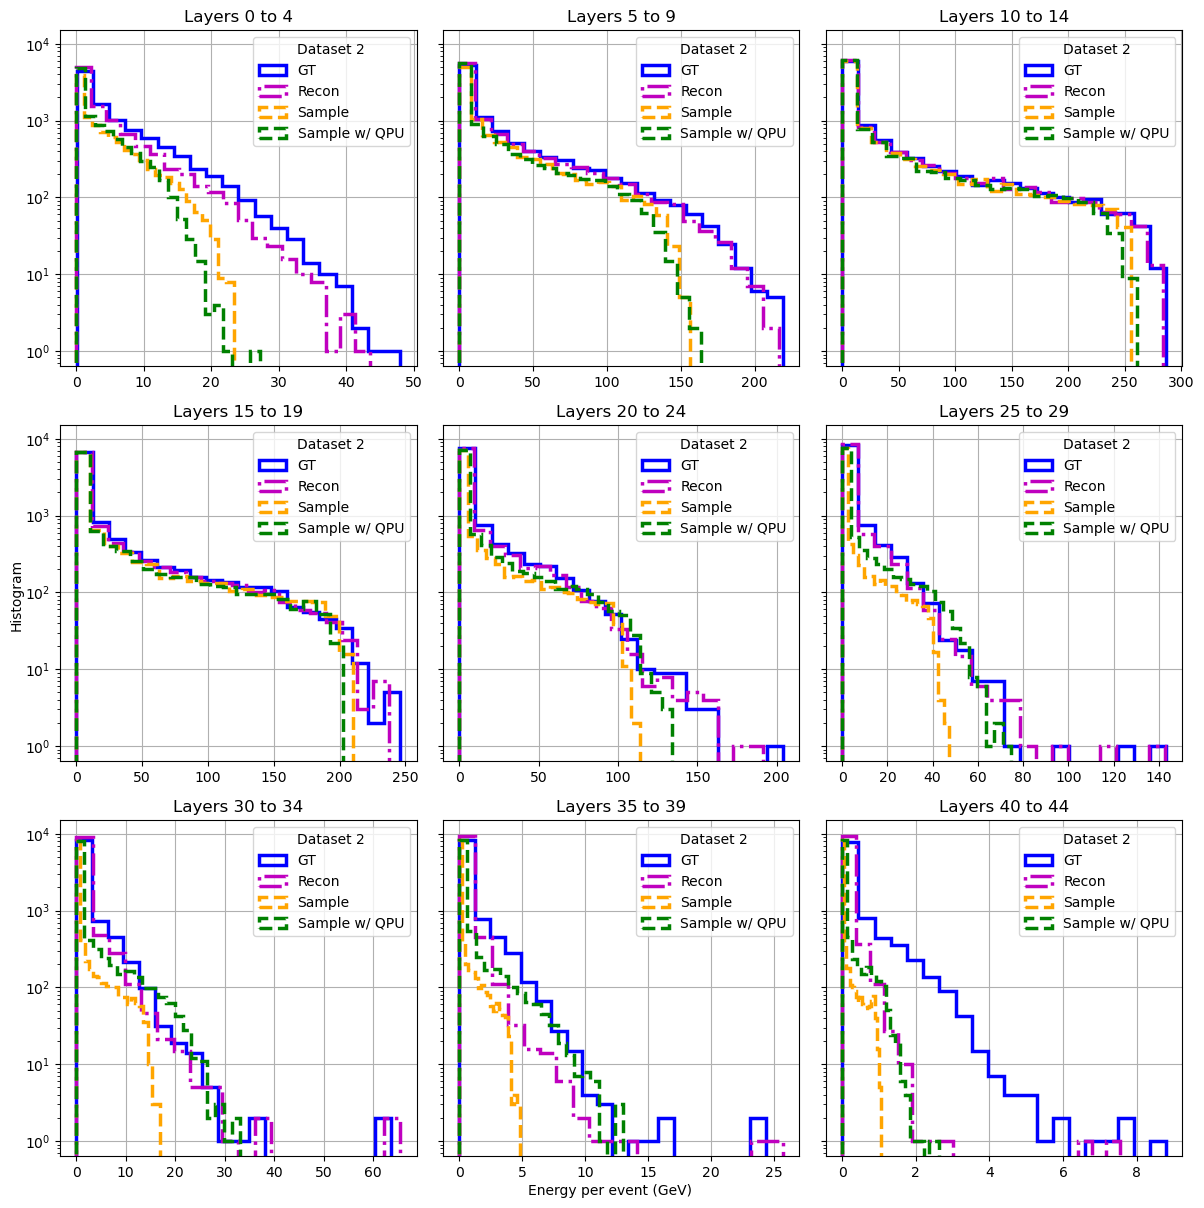

In [53]:
# HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    ax.hist(xgen_samples_qpu[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
    ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


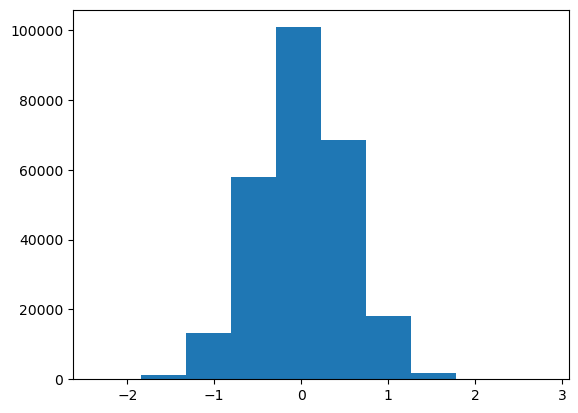

In [42]:
# plt.hist(engine._model.prior._weight_dict['23'].reshape(-1).detach().cpu().numpy())
# plt.show()
# engine._model.prior._weight_dict['01'].reshape(-1)

In [368]:
# idxPrev = 0
# # for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate([16*9*i for i in range(10,20)]):
# # for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.scatter(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, marker='.', alpha=.2)
#     plt.plot([0,xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000],[0,xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000], c='red', lw=2)
    
#     plt.xlabel("input energy per event (GeV)")
#     plt.ylabel("recon energy per event (GeV)")
#     plt.title(f'{part}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

In [151]:
np.unique(HLF_1_pions.bin_edges)

array([  0,   8, 108, 208, 213, 363, 523, 533])

In [153]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [35]:
if reducedata:
    in_data = engine._reduce(in_data, true_energy, R=R)
fwd_output = engine.model((in_data, true_energy), False)
if reducedata:
    in_data = engine._reduceinv(in_data, true_energy, R=R)
    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
elif scaled:
    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
    engine._model.sampler._batch_size = true_energy.shape[0]
    # try:
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    # except:
        # pass
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
else:
    in_data = in_data.detach().cpu()*1000
    recon_data = fwd_output.output_activations.detach().cpu()*1000
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = sample_data.detach().cpu()*1000

In [303]:
THRSH=7
recon_data = recon_data * (recon_data > THRSH)
sample_data = sample_data * (sample_data > THRSH)

In [44]:
HLF_1_pions.relevantLayers = [1,2,3,4,5,6,7]

In [121]:
HLF_1_electron.relevantLayers = [5,10,15,30,35]

In [45]:
# (((in_data[:,0:108] - recon_data[:,0:108])/(in_data[:,0:108]))**2).sum(dim=1).argsort()[:20]
(((in_data - recon_data)/(in_data+1e-5))**2).sum(dim=1).argsort()[-200:-1]
# (((in_data - recon_data))**2).sum(dim=1).argsort()[:20]

tensor([779, 684, 113, 335, 110, 119, 395, 151,  22, 171, 144, 709, 660, 313,
        298, 627, 109, 769, 189, 380, 214, 292, 404, 183, 410, 271, 149, 405,
        447, 653, 437, 334, 129, 289, 168,  36,  81,   4, 184, 143, 101, 159,
        629, 590, 284, 158, 435, 247, 757,  94, 729, 723, 181, 551, 642, 282,
          6, 316, 549, 391, 566, 702, 640, 496, 414, 486, 632, 136, 368, 643,
        767,  37,  75, 373, 553, 117, 630, 515,  27, 114, 196, 393, 658,  16,
        425,  93, 192, 349, 120, 178, 633, 616, 375,  96, 255, 204, 649,   2,
        154, 442, 164, 319, 300, 558, 215, 563, 736, 295, 253, 412,  39, 562,
        489, 501, 595, 721,  47, 205, 264, 753, 423, 720, 493,  59, 497, 461,
        661, 396, 417,  21, 523, 325, 297, 524, 186, 399, 663, 738, 195,  31,
        719, 507, 420, 418, 311, 288, 708, 116, 141, 536, 579, 140, 760, 754,
        452, 554, 198, 732, 145, 361, 366, 625,  83,  90, 619, 254, 468, 540,
        281, 727, 559, 212, 274,  14, 714, 752, 699, 219, 781, 3

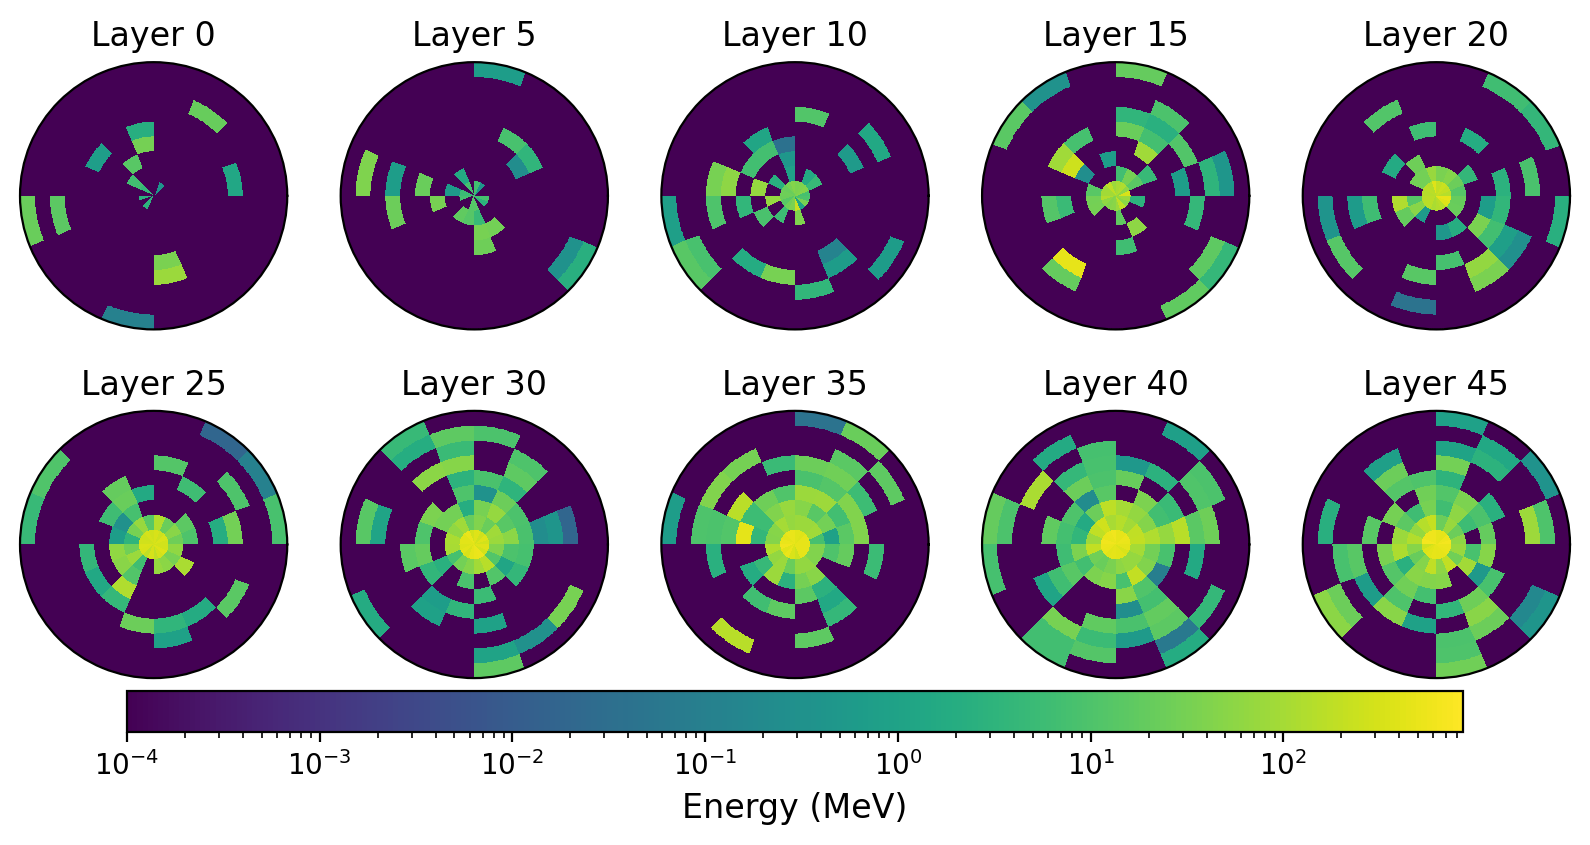

In [50]:
idx=779
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)


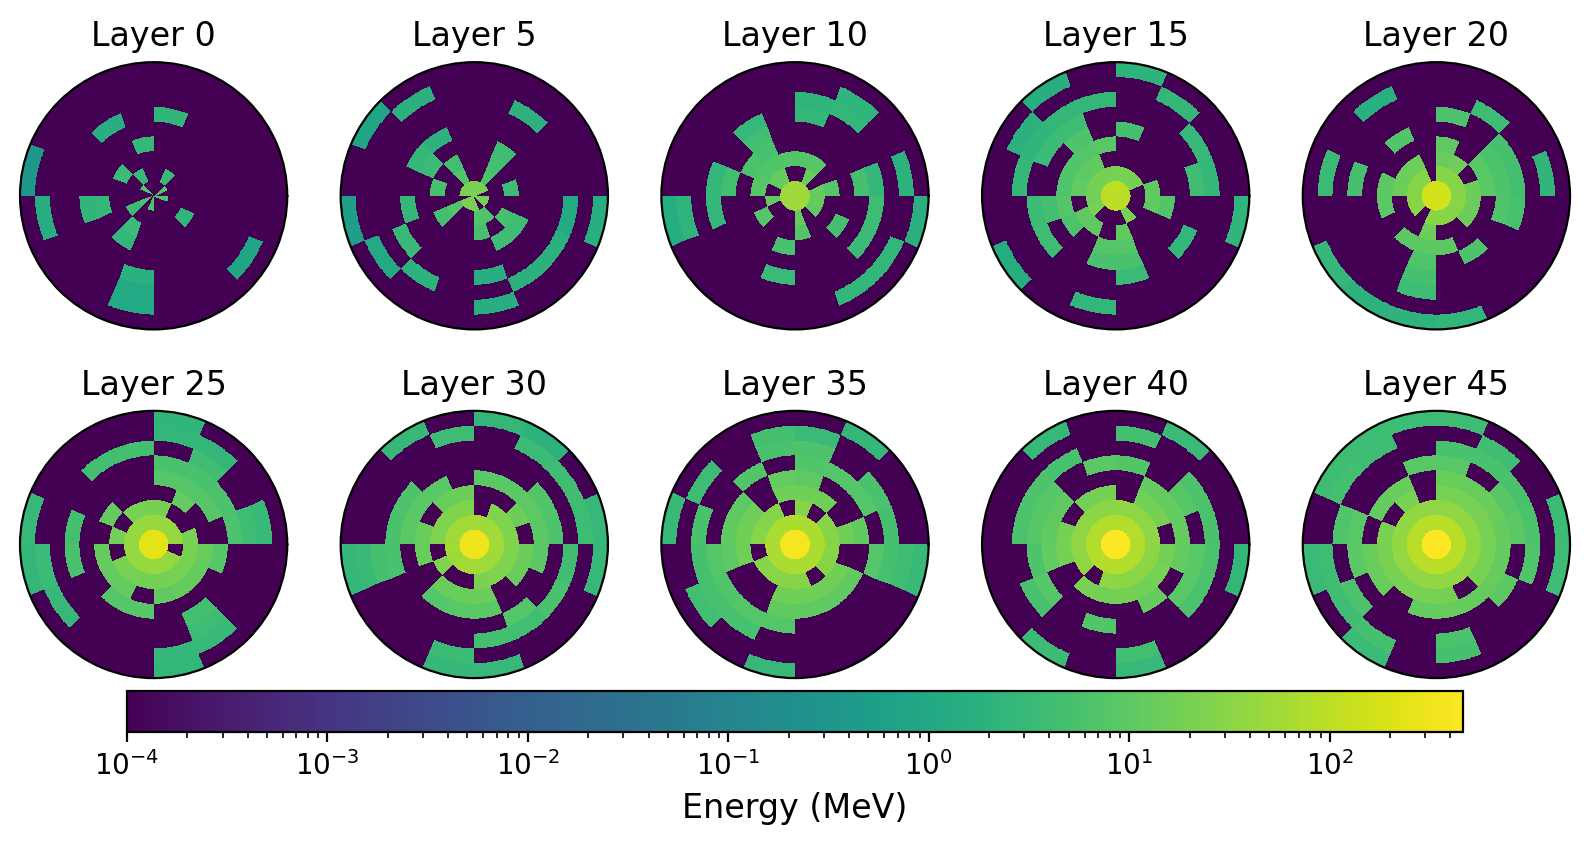

In [51]:
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)

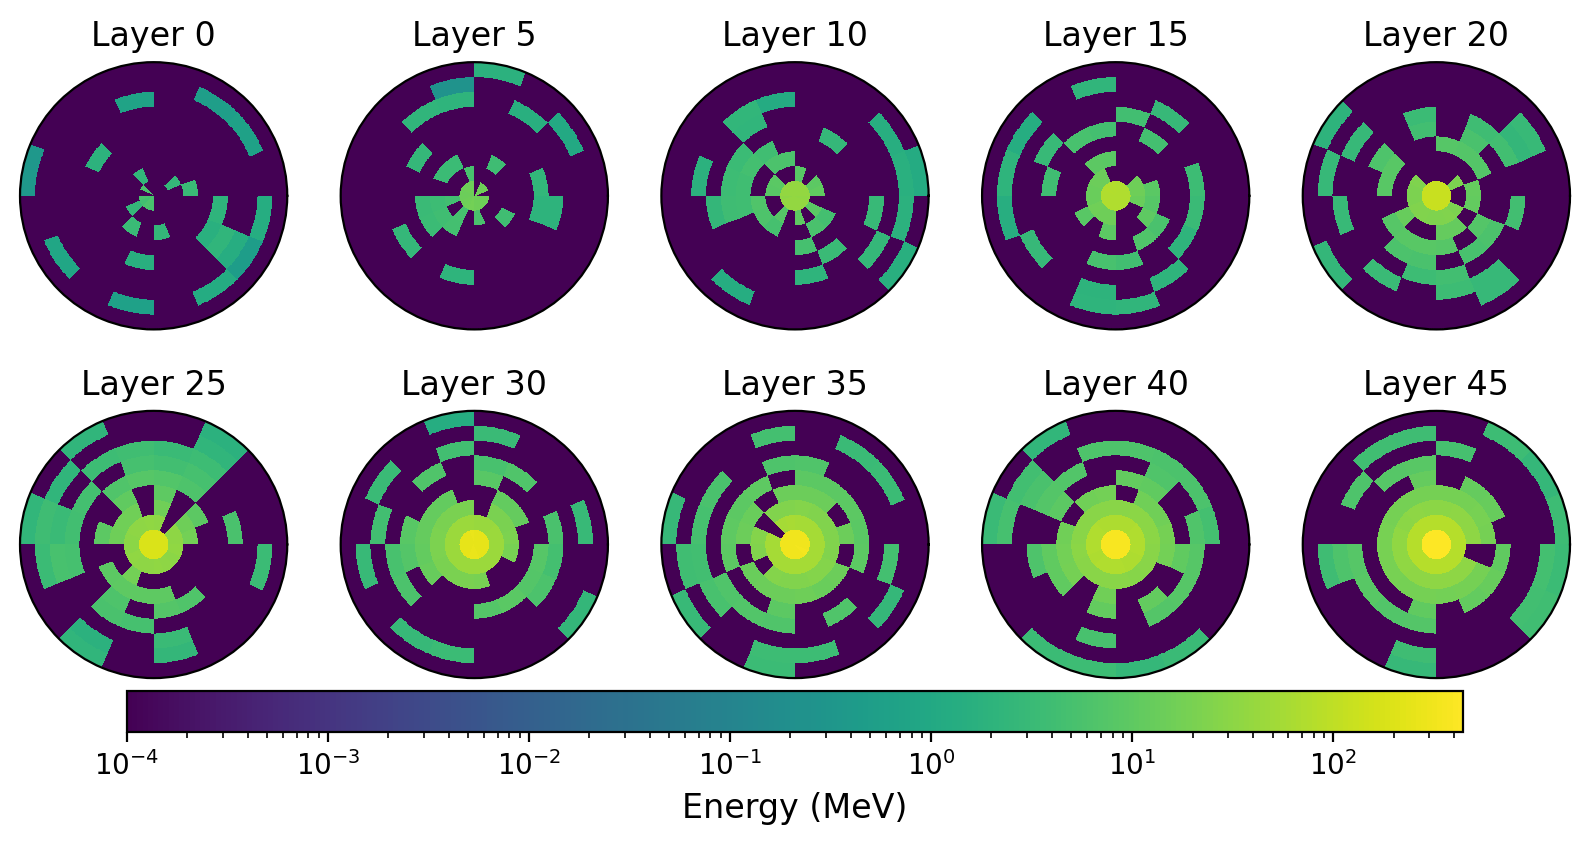

In [52]:
# HLF_1_pions.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(sample_data[1,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)

In [103]:
# HLF_1_electron.DrawSingleShower(sample_data_qpu[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_QPU_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(sample_data_qpu[idx,:].detach().cpu().numpy(), filename=None)

IndexError: index 6480 is out of bounds for dimension 0 with size 784

In [74]:
#Average Shower
modelname

'northern-meadow-223'

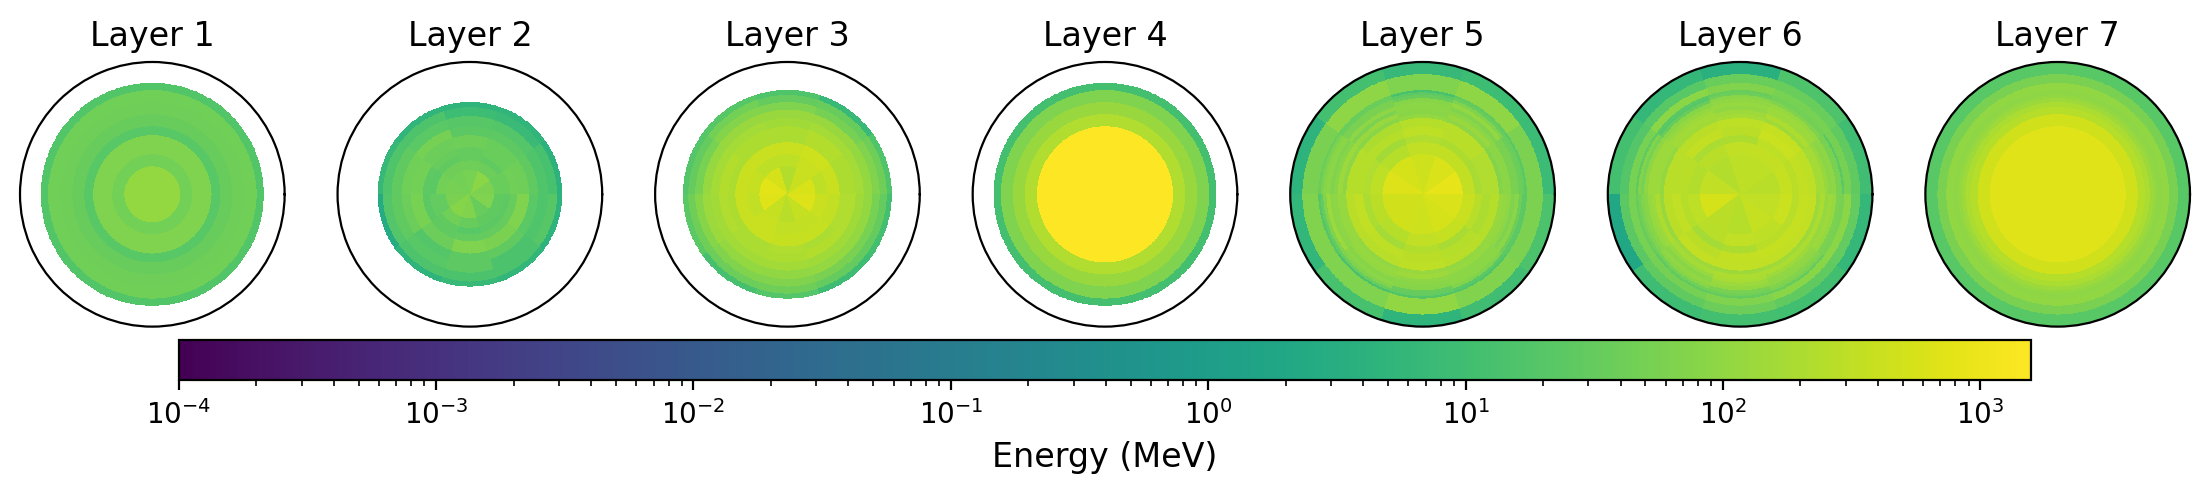

In [636]:
HLF_1_pions.DrawAverageShower(in_data[idx:idx+100,:].detach().cpu().numpy(), filename=None)

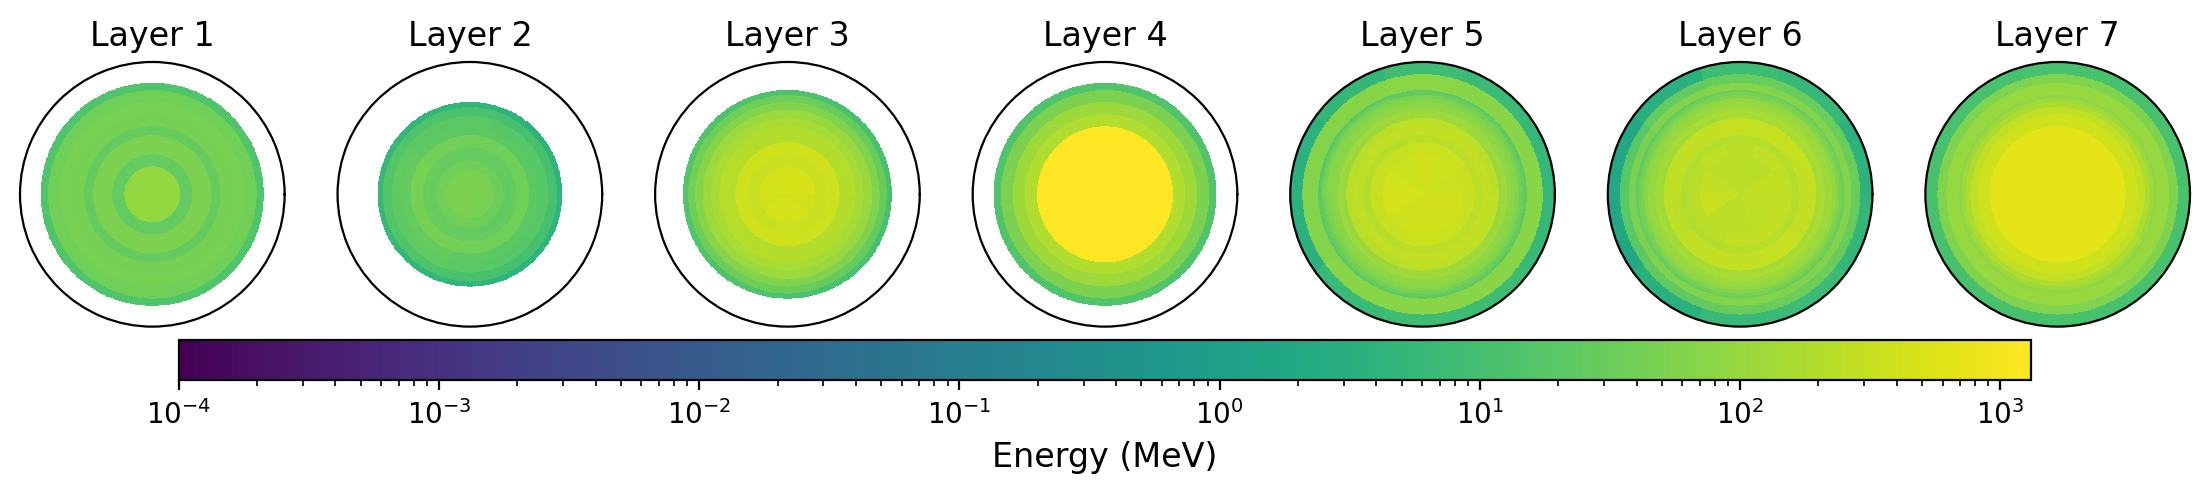

In [637]:
HLF_1_pions.DrawAverageShower(recon_data[idx:idx+100,:].detach().cpu().numpy(), filename=None)

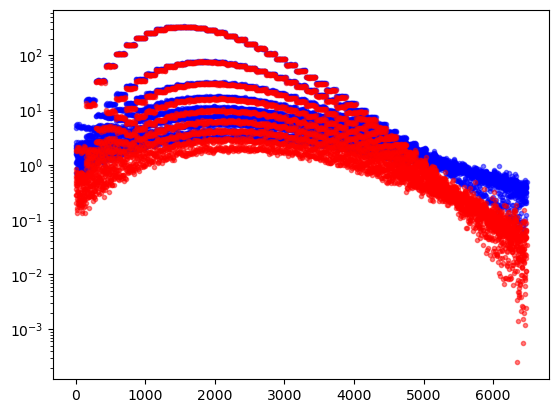

In [104]:
plt.plot(xtarget_samples.mean(dim=0).numpy(), marker='.', alpha=.5, color="b", linewidth=0)
plt.plot(xrecon_samples.mean(dim=0).numpy(), marker='.', alpha=.5, color="r", linewidth=0)
plt.yscale('log')
plt.yscale('log')
plt.show()

In [ ]:
# LL

In [83]:
ww = load_RBM_state("/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/RBM/RBM_1_9_weights.pth", dev)

[18:37:33.760] INFO   __main__                                          Loading RBM state


In [87]:
lnZais_list = []
lnZrais_list = []
for i in range(1,10):
    # print(i)
    engine_2.model.sampler._prbm._weight_dict = load_RBM_state(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/RBM/RBM_{i}_9_weights.pth', dev)
    engine_2.model.sampler._prbm._bias_dict = load_RBM_state(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/RBM/RBM_{i}_9_biases.pth', dev)
    lnZais_list.append(engine_2.model.stater.AIS(30).detach().cpu().item())
    lnZrais_list.append(engine_2.model.stater.RAIS(30).detach().cpu().item())
    

[18:38:12.980] INFO   __main__                                          Loading RBM state
[18:38:12.986] INFO   __main__                                          Loading RBM state
[18:40:27.983] INFO   __main__                                          Loading RBM state
[18:40:27.990] INFO   __main__                                          Loading RBM state
[18:42:44.059] INFO   __main__                                          Loading RBM state
[18:42:44.064] INFO   __main__                                          Loading RBM state
[18:45:00.901] INFO   __main__                                          Loading RBM state
[18:45:00.907] INFO   __main__                                          Loading RBM state
[18:47:16.877] INFO   __main__                                          Loading RBM state
[18:47:16.882] INFO   __main__                                          Loading RBM state
[18:49:32.233] INFO   __main__                                          Loading RBM state
[18:49:32.

In [103]:
for i in range(50,88):
    print(i)
    engine_2.model.sampler._prbm._weight_dict = load_RBM_state(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/RBM/RBM_{i}_9_weights.pth', dev)
    engine_2.model.sampler._prbm._bias_dict = load_RBM_state(f'/home/javier/Projects/CaloQVAE/outputs/2023-11-21/13-09-06/wandb/latest-run/files/RBM/RBM_{i}_9_biases.pth', dev)
    lnZais_list.append(engine_2.model.stater.AIS(30).detach().cpu().item())
    lnZrais_list.append(engine_2.model.stater.RAIS(30).detach().cpu().item())

[18:13:19.688] INFO   __main__                                          Loading RBM state
[18:13:19.693] INFO   __main__                                          Loading RBM state


50


[18:15:36.080] INFO   __main__                                          Loading RBM state
[18:15:36.086] INFO   __main__                                          Loading RBM state


51


[18:17:52.972] INFO   __main__                                          Loading RBM state
[18:17:52.976] INFO   __main__                                          Loading RBM state


52


[18:20:08.223] INFO   __main__                                          Loading RBM state
[18:20:08.227] INFO   __main__                                          Loading RBM state


53


[18:22:23.146] INFO   __main__                                          Loading RBM state
[18:22:23.152] INFO   __main__                                          Loading RBM state


54


[18:24:39.829] INFO   __main__                                          Loading RBM state
[18:24:39.834] INFO   __main__                                          Loading RBM state


55


[18:26:54.031] INFO   __main__                                          Loading RBM state
[18:26:54.036] INFO   __main__                                          Loading RBM state


56


[18:29:07.903] INFO   __main__                                          Loading RBM state
[18:29:07.908] INFO   __main__                                          Loading RBM state


57


[18:31:22.507] INFO   __main__                                          Loading RBM state
[18:31:22.512] INFO   __main__                                          Loading RBM state


58


[18:33:37.644] INFO   __main__                                          Loading RBM state
[18:33:37.649] INFO   __main__                                          Loading RBM state


59


[18:35:52.704] INFO   __main__                                          Loading RBM state
[18:35:52.709] INFO   __main__                                          Loading RBM state


60


[18:38:08.393] INFO   __main__                                          Loading RBM state
[18:38:08.399] INFO   __main__                                          Loading RBM state


61


[18:40:23.931] INFO   __main__                                          Loading RBM state
[18:40:23.936] INFO   __main__                                          Loading RBM state


62


[18:42:39.156] INFO   __main__                                          Loading RBM state
[18:42:39.161] INFO   __main__                                          Loading RBM state


63


[18:44:53.403] INFO   __main__                                          Loading RBM state
[18:44:53.408] INFO   __main__                                          Loading RBM state


64


[18:47:10.932] INFO   __main__                                          Loading RBM state
[18:47:10.938] INFO   __main__                                          Loading RBM state


65


[18:49:28.836] INFO   __main__                                          Loading RBM state
[18:49:28.841] INFO   __main__                                          Loading RBM state


66


[18:51:43.055] INFO   __main__                                          Loading RBM state
[18:51:43.060] INFO   __main__                                          Loading RBM state


67


[18:53:57.730] INFO   __main__                                          Loading RBM state
[18:53:57.735] INFO   __main__                                          Loading RBM state


68


[18:56:12.190] INFO   __main__                                          Loading RBM state
[18:56:12.195] INFO   __main__                                          Loading RBM state


69


[18:58:26.555] INFO   __main__                                          Loading RBM state
[18:58:26.560] INFO   __main__                                          Loading RBM state


70


[19:00:41.825] INFO   __main__                                          Loading RBM state
[19:00:41.830] INFO   __main__                                          Loading RBM state


71


[19:02:56.244] INFO   __main__                                          Loading RBM state
[19:02:56.249] INFO   __main__                                          Loading RBM state


72


[19:05:12.344] INFO   __main__                                          Loading RBM state
[19:05:12.349] INFO   __main__                                          Loading RBM state


73


[19:07:26.442] INFO   __main__                                          Loading RBM state
[19:07:26.449] INFO   __main__                                          Loading RBM state


74


[19:09:40.474] INFO   __main__                                          Loading RBM state
[19:09:40.479] INFO   __main__                                          Loading RBM state


75


[19:11:54.736] INFO   __main__                                          Loading RBM state
[19:11:54.741] INFO   __main__                                          Loading RBM state


76


[19:14:09.055] INFO   __main__                                          Loading RBM state
[19:14:09.060] INFO   __main__                                          Loading RBM state


77


[19:16:22.894] INFO   __main__                                          Loading RBM state
[19:16:22.899] INFO   __main__                                          Loading RBM state


78


[19:18:36.563] INFO   __main__                                          Loading RBM state
[19:18:36.568] INFO   __main__                                          Loading RBM state


79


[19:20:50.627] INFO   __main__                                          Loading RBM state
[19:20:50.633] INFO   __main__                                          Loading RBM state


80


[19:23:05.231] INFO   __main__                                          Loading RBM state
[19:23:05.235] INFO   __main__                                          Loading RBM state


81


[19:25:19.039] INFO   __main__                                          Loading RBM state
[19:25:19.044] INFO   __main__                                          Loading RBM state


82


[19:27:32.539] INFO   __main__                                          Loading RBM state
[19:27:32.543] INFO   __main__                                          Loading RBM state


83


[19:29:46.117] INFO   __main__                                          Loading RBM state
[19:29:46.121] INFO   __main__                                          Loading RBM state


84


[19:32:01.155] INFO   __main__                                          Loading RBM state
[19:32:01.160] INFO   __main__                                          Loading RBM state


85


[19:34:16.122] INFO   __main__                                          Loading RBM state
[19:34:16.127] INFO   __main__                                          Loading RBM state


86


[19:36:31.777] INFO   __main__                                          Loading RBM state
[19:36:31.782] INFO   __main__                                          Loading RBM state


87


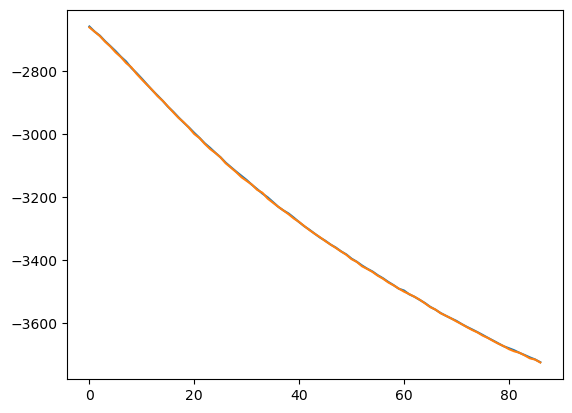

In [104]:
# plt.plot(-energy_encoded_data.mean()-np.array(lnZais_list))
# plt.plot(-energy_encoded_data.mean()-np.array(lnZrais_list))
plt.plot(-np.array(lnZais_list))
plt.plot(-np.array(lnZrais_list))

In [54]:
prelu_dict = {}
for i in range(4):
    for name, param in engine.model.encoder._networks[i][0].seq2[4].named_parameters():
        # print(name, param.data.detach().cpu().numpy())
        prelu_dict[i] = param.data.detach().cpu().numpy()

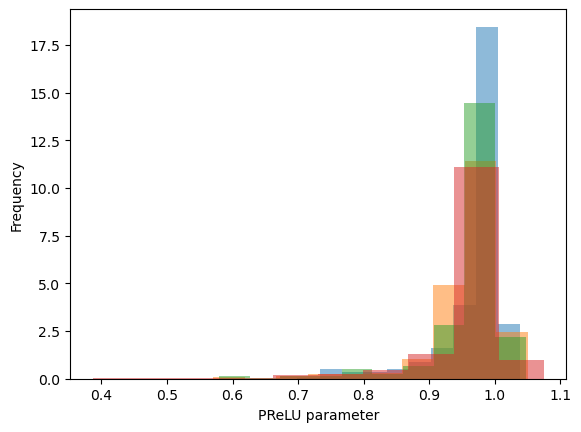

In [56]:
for i in range(4):
    plt.hist(prelu_dict[i], alpha=0.5, density=True)
plt.xlabel("PReLU parameter")
plt.ylabel("Frequency")
plt.show()

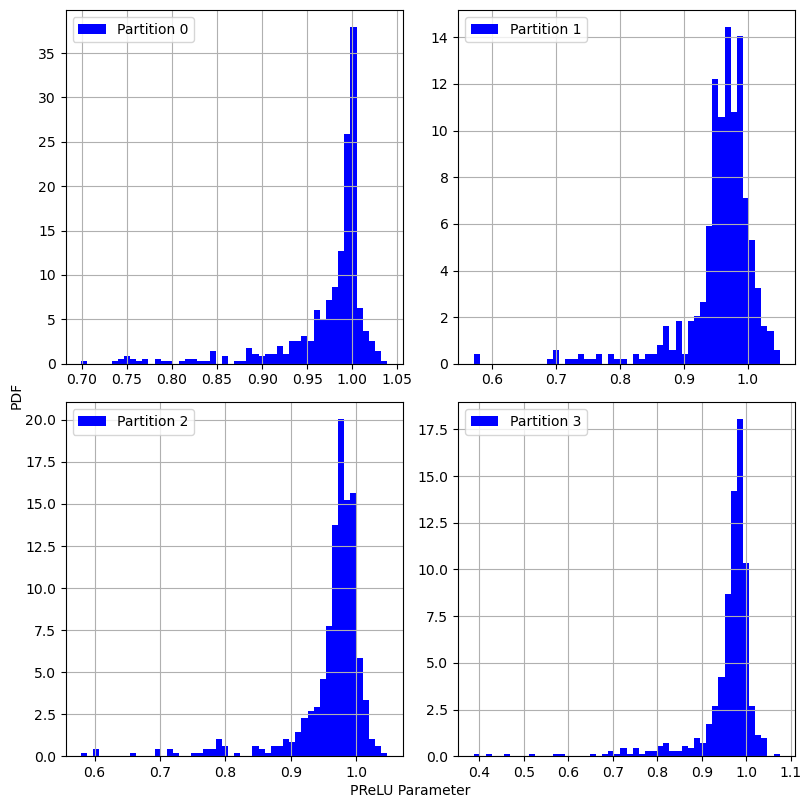

In [76]:
fig, axes = plt.subplots(2,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'PReLU Parameter', ha='center')
# fig.text(0.5, 1.0, f'PDF', ha='center', fontsize=12)
fig.text(0.0, 0.5, 'PDF', va='center', rotation='vertical')

axes[0,0].hist(prelu_dict[0], bins=50, density=True, color="b")
axes[0,0].legend(["Partition 0"])
axes[0,0].grid("True")

axes[0,1].hist(prelu_dict[1], bins=50, color="b", density=True)
axes[0,1].legend(["Partition 1"])
axes[0,1].grid("True")

axes[1,0].hist(prelu_dict[2], bins=50, color="b", density=True)
axes[1,0].legend(["Partition 2"])
axes[1,0].grid("True")

axes[1,1].hist(prelu_dict[3], bins=50, color="b", density=True)
axes[1,1].legend(["Partition 3"])
axes[1,1].grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/PReLU_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [97]:
# engine.model.encoder(in_data.to(dev), true_energy.to(dev), False)
x = engine.model.encoder._networks[0][0].seq1(in_data.to(dev))

In [96]:
in_data.shape
x0 = true_energy.to(dev)

In [99]:
# xxx
x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item()).divide(1000.0).shape

torch.Size([784, 1, 5, 5])

In [116]:
x0.unsqueeze(2).unsqueeze(3).repeat(1, x.size(1), x.size(2), x.size(3)).divide(1000.0) + x

tensor([[[[5.3387e+00, 1.0305e+01, 1.0073e+01, 6.5133e+00, 3.2716e+00],
          [3.2619e+00, 3.2587e+00, 3.2712e+00, 3.2728e+00, 3.2738e+00],
          [8.9058e+00, 2.8647e+01, 2.8218e+01, 1.8247e+01, 5.7551e+00],
          [3.2619e+00, 3.2716e+00, 6.7858e+00, 3.2748e+00, 3.2584e+00],
          [3.2658e+00, 3.9510e+00, 3.5585e+00, 3.2623e+00, 3.2734e+00]],

         [[2.8044e+00, 2.9771e+00, 2.6383e+00, 2.9956e+00, 3.2183e+00],
          [2.6297e+00, 1.6182e+00, 2.5280e+00, 2.8630e+00, 3.0869e+00],
          [2.3770e+00, 3.1063e+00, 2.5158e+00, 3.1111e+00, 6.2443e+00],
          [2.9254e+00, 1.8511e+00, 2.9036e+00, 2.3626e+00, 3.1757e+00],
          [3.1786e+00, 4.5602e+00, 3.0621e+00, 3.2207e+00, 3.2410e+00]],

         [[3.0290e+00, 2.8760e+00, 2.8088e+00, 3.1570e+00, 7.2084e+00],
          [3.0828e+00, 3.0977e+00, 4.1414e+00, 1.4701e+01, 5.9458e+00],
          [3.0313e+00, 2.6295e+00, 2.7758e+00, 3.0429e+00, 4.1907e+00],
          [2.9268e+00, 2.9860e+00, 3.0483e+00, 5.5577e+00, 3

In [112]:
x0.shape

torch.Size([784, 1])

In [113]:
x.size()

torch.Size([784, 256, 5, 5])